In [1]:
# More distance stuff
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
# Importing GemPy
import gempy as gp
# Embedding matplotlib figures in the notebooks
%matplotlib inline
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3D visualization
import pyvista as pv

In [2]:
os.pardir = '../..'

In [3]:
res = [5,5,5]
dim = 3

In [4]:
# set resolution, extent and input data
geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=res, 
                        path_o = os.pardir+"/data/input_data/jan_models/model2b_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model2b_surface_points.csv") 

Active grids: ['regular']


In [5]:
# set colors just for me #F4B400 #DB4437 #4285F4
geo_data.surfaces.colors.change_colors({"rock1": '#DB4437', "rock2": "#4285F4", "basement": "#F4B400"})

,surface,series,order_surfaces,isBasement,color,id
0,rock1,Default series,1,False,#DB4437,1
1,rock2,Default series,2,False,#4285F4,2
2,basement,Basement,1,True,#F4B400,3


In [6]:
# define series and assign surfaces
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock1,Strat_Series,1,False,#DB4437,1
1,rock2,Strat_Series,2,False,#4285F4,2
2,basement,Basement_Series,1,True,#F4B400,3


In [7]:
# define the interpolator
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [8]:
#gp.plot.plot_data(geo_data)

In [9]:
#calcualte the solution
sol = gp.compute_model(geo_data, compute_mesh=False)

In [10]:
# Plot the scalar field classic option
#gp.plot.plot_scalar_field(geo_data, cell_number=int(res[0]/2), direction='y')

In [11]:
# Plot the section
#gp.plot.plot_section(geo_data, cell_number=int(res[0]/2))

In [12]:
from numpy import cross, eye, dot
from scipy.linalg import expm, norm

# function to rotatate around axis by theta angle
def M(axis, theta):
    return expm(cross(eye(3), axis/norm(axis)*theta))

def get_gradient(sol):
    '''
    Calculate gradient from model solution
    '''
    # scalar field as meshgrid
    scalar_mgrid = sol.scalar_field_matrix.reshape(res)

    # calculate gradient
    gx, gy, gz = np.gradient(scalar_mgrid)

    # get coordinates
    x =  np.unique(sol.grid.regular_grid.values[:,0])
    y =  np.unique(sol.grid.regular_grid.values[:,1])
    z =  np.unique(sol.grid.regular_grid.values[:,2])

    # I switch X and Y here (miguel: depends on matrix/array indexing/notation)
    # figure that out later
    Y, X, Z = np.meshgrid(x, y, z)
    
    vectors = np.array([gx.reshape(int(res[0]**dim)),gy.reshape(int(res[0]**dim)),gz.reshape(int(res[0]**dim))])
    vectors = np.swapaxes(vectors, 0, 1)
    
    return vectors, X, Y, Z

def rotate_gradient_field(gradient_field):
    '''
    Function to calculate rotated gradient field in x and y direction.
    '''
    # emtpy containers for rotated gradients
    rot_vectors_x = np.zeros(vectors.shape)
    rot_vectors_y = np.zeros(vectors.shape)
    
    # first rotate in x direction (around y axis) - vectorized version
    vec, axis, theta = (vectors), [0,1,0], np.pi/2
    M0 = M(axis, theta)
    rot_vectors_x = vec.dot(M0.T)
    
    # TODO: Can this be vectorized?
    # then use results to get normal - rotation in y direction
    for i in range(len(vectors)):
        vec, axis, theta = (vectors[i]), rot_vectors_x[i], np.pi/2
        M0 = M(axis, theta)
        rot_vectors_y[i]=np.dot(M0,vec)
    
    return rot_vectors_x, rot_vectors_y

In [115]:
# Plotting functions
def plot_scalar_field_3D(model, mode='block', surfaces_nr=10):
    # option for layers or block
    res = model.grid.regular_grid.resolution
    values = model.solutions.scalar_field_matrix.reshape(res)
    
    x = model.grid.values[:,0].reshape(res)
    y = model.grid.values[:,1].reshape(res)
    z = model.grid.values[:,2].reshape(res)
    
    grid = pv.StructuredGrid(z, y, x)
    p = pv.BackgroundPlotter()
    
    if mode == 'block':
        # This is how to plot a scalar field block - Wrap it in function
        p.add_mesh(grid, scalars=values.flatten(), show_edges=True)
        p.add_axes()
        p.show()
        
    elif mode == 'surfaces':
        # plot surfaces 
        grid["vol"] = values.flatten()
        contours = grid.contour(np.linspace(values.min(), values.max(), surfaces_nr+2))
        #p.add_mesh(contours, show_scalar_bar=True, color='black', label="scalar_field_main")
        p.add_mesh(contours, show_scalar_bar=True, label="scalar_field_main")
    
    p.add_axes()
    p.show()

In [125]:
plot_scalar_field_3D(geo_data)

In [124]:
plot_scalar_field_3D(geo_data, 'surfaces')

In [120]:
vectors, X, Y, Z = get_gradient(sol) 
rot_vectors_x, rot_vectors_y = rotate_gradient_field(vectors)

In [49]:
gx = vectors[:,0].reshape(res)
gy = vectors[:,1].reshape(res)
gz = vectors[:,2].reshape(res)

gx_x = rot_vectors_x[:,0].reshape(res)
gy_x = rot_vectors_x[:,1].reshape(res)
gz_x = rot_vectors_x[:,2].reshape(res)

gx_y = rot_vectors_y[:,0].reshape(res)
gy_y = rot_vectors_y[:,1].reshape(res)
gz_y = rot_vectors_y[:,2].reshape(res)

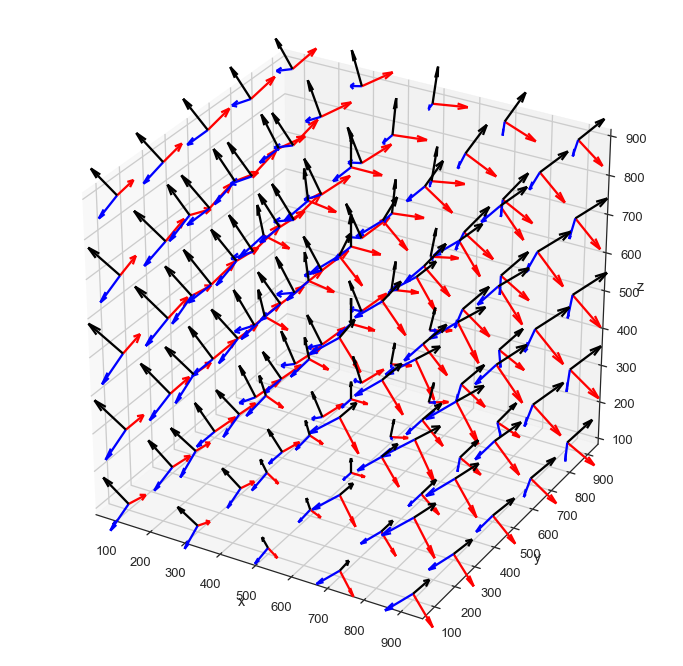

In [126]:
# figure out pyvista version of this ...

#%matplotlib notebook
%matplotlib inline

# This somehow works for the x direction, but more clear way wath propper vector rotation should be nicer
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
#ax.scatter(sol.grid.regular_grid.values[:,0], sol.grid.regular_grid.values[:,1],sol.grid.regular_grid.values[:,2], c=sol.lith_block, cmap='viridis')

# switch to naming convention, scale
factor=500

u=gx*factor
v=gy*factor
w=gz*factor

u_x=gx_x*factor
v_x=gy_x*factor
w_x=gz_x*factor

u_y=gx_y*factor
v_y=gy_y*factor
w_y=gz_y*factor

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# plot arrows
# main(z)
ax.quiver(X, Y, Z, u, v, w, color='black')
# x direction
ax.quiver(X, Y, Z, u_x, v_x, w_x, color='red')
# y direction
ax.quiver(X, Y, Z, u_y, v_y, w_y, color='blue')

plt.show()
#ax.view_init(90,0)


In [127]:
# Figure out smart way to create new gempy models and everything ... infrastructure and shit

In [128]:
# set resolution, extent and input data
geo_data2 = gp.create_data([0,1000,0,1000,0,1000],resolution=[25,25,25])
                        #path_o = os.pardir+"/data/input_data/jan_models/model2b_orientations.csv",
                        #path_i = os.pardir+"/data/input_data/jan_models/model2b_surface_points.csv") 


Active grids: ['regular']


In [22]:
geo_data2.add_surfaces("two")
geo_data2.add_surfaces("one")
geo_data2.add_surfaces("Basement")

,surface,series,order_surfaces,isBasement,color,id
0,two,Default series,1,False,#015482,1
1,one,Default series,2,False,#9f0052,2
2,Basement,Default series,3,True,#ffbe00,3


In [23]:
geo_data2.add_surface_points(1000, 500, 300, "one")
geo_data2.add_surface_points(1000, 500, 300, "one")
geo_data2.add_surface_points(0, 500, 300, "two")
geo_data2.add_surface_points(0, 500, 300, "two")


,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
2,0.0,500.0,300.0,0.2501,0.5001,0.5001,two,Default series,1,1,0.000001
3,0.0,500.0,300.0,0.2501,0.5001,0.5001,two,Default series,1,1,0.000001
0,1000.0,500.0,300.0,0.7501,0.5001,0.5001,one,Default series,2,1,0.000001
1,1000.0,500.0,300.0,0.7501,0.5001,0.5001,one,Default series,2,1,0.000001


In [24]:
geo_data2.orientations.set_orientations(geo_data.grid.regular_grid.values, 
                           rot_vectors_x*5, 
                           surface=['one']*len(vectors))

In [25]:
geo_data2.orientations

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,100.0,100.0,100.0,NaN,NaN,NaN,0.671027,-2.345659e-01,5.609098e-01,55.881260,109.267705,1,one,Default series,NaN,1,0.01
1,100.0,100.0,300.0,NaN,NaN,NaN,0.703411,-2.548267e-01,7.096763e-01,44.791412,109.914075,1,one,Default series,NaN,1,0.01
2,100.0,100.0,500.0,NaN,NaN,NaN,0.676781,-2.482898e-01,7.952057e-01,37.325313,110.146512,1,one,Default series,NaN,1,0.01
3,100.0,100.0,700.0,NaN,NaN,NaN,0.604694,-2.030988e-01,7.384555e-01,42.399988,108.565670,1,one,Default series,NaN,1,0.01
4,100.0,100.0,900.0,NaN,NaN,NaN,0.591621,-1.738171e-01,5.912639e-01,53.753251,106.372680,1,one,Default series,NaN,1,0.01
5,100.0,300.0,100.0,NaN,NaN,NaN,0.650766,-1.667936e-01,5.833134e-01,54.316073,104.375649,1,one,Default series,NaN,1,0.01
6,100.0,300.0,300.0,NaN,NaN,NaN,0.696549,-1.843838e-01,7.237772e-01,43.632782,104.826723,1,one,Default series,NaN,1,0.01
7,100.0,300.0,500.0,NaN,NaN,NaN,0.702645,-1.763806e-01,8.139597e-01,35.515373,104.091445,1,one,Default series,NaN,1,0.01
8,100.0,300.0,700.0,NaN,NaN,NaN,0.641930,-1.422484e-01,7.888203e-01,37.924600,102.494545,1,one,Default series,NaN,1,0.01
9,100.0,300.0,900.0,NaN,NaN,NaN,0.620903,-1.234007e-01,6.570086e-01,48.927873,101.240714,1,one,Default series,NaN,1,0.01


In [26]:
# define the interpolator
interp_data2 = gp.set_interpolation_data(geo_data2, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [27]:
#calcualte the solution
sol2 = gp.compute_model(geo_data2, compute_mesh=False)

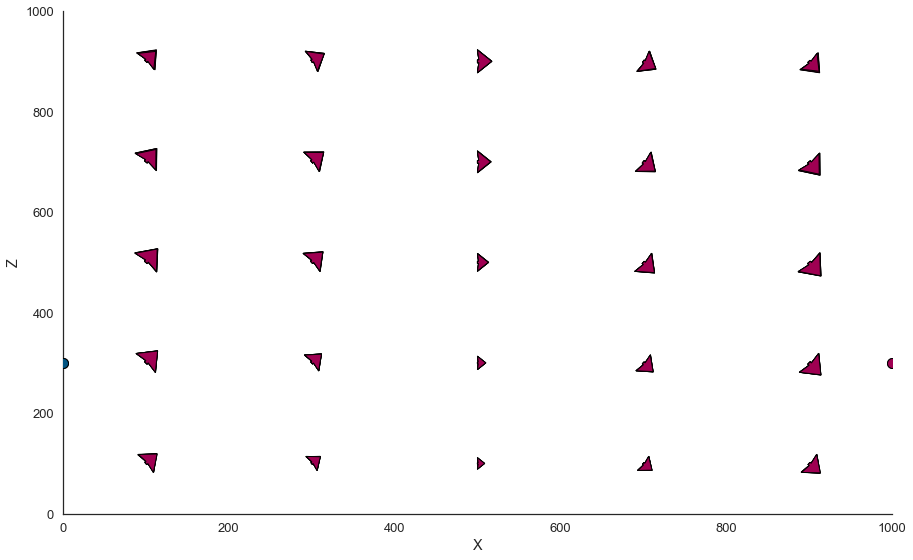

In [28]:
gp.plot.plot_data(geo_data2, direction='y')

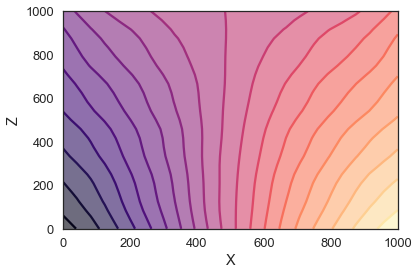

In [29]:
gp.plot.plot_scalar_field(geo_data2, cell_number=24, direction='y')

In [30]:
# Y-direction
# set resolution, extent and input data
geo_data3 = gp.create_data([0,1000,0,1000,0,1000],resolution=[25,25,25])
                        #path_o = os.pardir+"/data/input_data/jan_models/model2b_orientations.csv",
                        #path_i = os.pardir+"/data/input_data/jan_models/model2b_surface_points.csv") 

geo_data3.add_surfaces("two")
geo_data3.add_surfaces("one")
geo_data3.add_surfaces("Basement")

geo_data3.add_surface_points(500, 0, 300, "two")
geo_data3.add_surface_points(500, 0, 300, "two")
geo_data3.add_surface_points(500, 1000, 300, "one")
geo_data3.add_surface_points(500, 1000, 300, "one")

geo_data3.orientations.set_orientations(geo_data.grid.regular_grid.values, 
                            rot_vectors_y*10, 
                           surface=['one']*len(vectors))

Active grids: ['regular']


In [31]:
# define the interpolator
interp_data3 = gp.set_interpolation_data(geo_data3, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [32]:
#calcualte the solution
sol3 = gp.compute_model(geo_data3, compute_mesh=False)

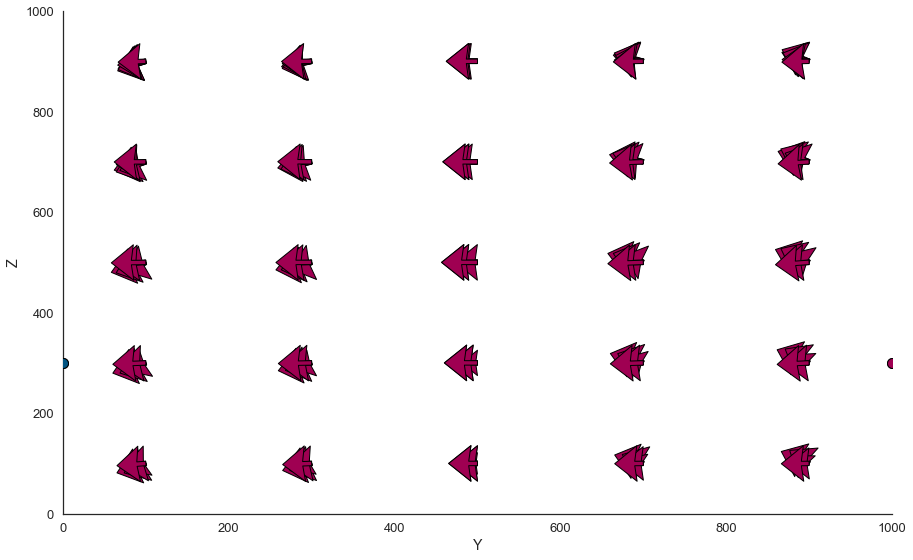

In [33]:
gp.plot.plot_data(geo_data3, direction='x')

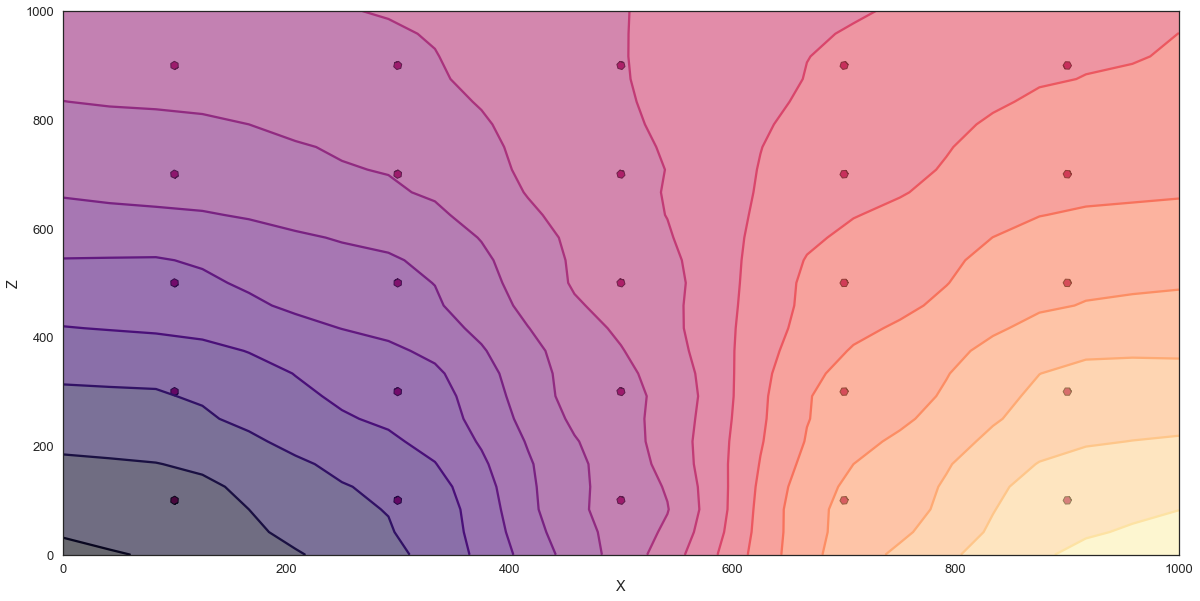

In [34]:
CS = gp.plot.plot_scalar_field(geo_data3, cell_number=12, direction='y')


In [35]:
# TODO

# normalize vector and check effect on result
# option to plot scalar field values in plot (push)
# 3D visualization of 3D gradient field

In [36]:
# Maybe the stuff above is even correct... THEN how can I make a distance out of this?

# Pick two points and check the differences.
# label scalar field lines. 
# do more stuff

In [37]:
geo_data2.solutions.scalar_field_matrix.shape

(1, 15625)

In [38]:
geo_data2.grid.values.shape

(15625, 3)

In [39]:
import pyvista as pv

In [40]:
# This works and looks pretty good, need to make a function out of this...

In [41]:
scalar = geo_data.solutions.scalar_field_matrix
coords = geo_data.grid.values

scalar2 = geo_data2.solutions.scalar_field_matrix
coords2 = geo_data2.grid.values

scalar3 = geo_data3.solutions.scalar_field_matrix
coords3 = geo_data3.grid.values

In [58]:
scalar = scalar.reshape([5,5,5])

x = coords[:,0].reshape([5,5,5])
y = coords[:,1].reshape([5,5,5])
z = coords[:,2].reshape([5,5,5])

grid = pv.StructuredGrid(x, y, z)
grid["vol"] = scalar.flatten()

contours = grid.contour([0.1, 0.5, 0.7])

In [43]:
scalar2 = scalar2.reshape([25,25,25])

x2 = coords2[:,0].reshape([25,25,25])
y2 = coords2[:,1].reshape([25,25,25])
z2 = coords2[:,2].reshape([25,25,25])

grid2 = pv.StructuredGrid(x2, y2, z2)
grid2["vol"] = scalar2.flatten()

print(scalar2.min())

0.036977272117073745


In [44]:
scalar3 = scalar3.reshape([25,25,25])

x3 = coords3[:,0].reshape([25,25,25])
y3 = coords3[:,1].reshape([25,25,25])
z3 = coords3[:,2].reshape([25,25,25])

grid3 = pv.StructuredGrid(x3, y3, z3)
grid3["vol"] = scalar3.flatten()

In [45]:
contours2 = grid2.contour(np.linspace(scalar2.min(), scalar2.max(), 8))
contours3 = grid3.contour(np.linspace(scalar3.min(), scalar3.max(), 8))
contours = grid.contour(np.linspace(scalar.min(), scalar.max(), 8))


In [46]:
#%% Visualization
#pv.set_plot_theme('document')
p = pv.BackgroundPlotter()
#p = pv.Plotter()
p.add_mesh(contours, show_scalar_bar=True, color='black', label="scalar_field_main")
p.add_mesh(contours2, show_scalar_bar=True, color='blue', label="scalar_field_x")
p.add_mesh(contours3, show_scalar_bar=True, color='red', label="scalar_field_y")


p.show()


In [47]:
# BIG QUESTION: how to define anchor points!!! (automatically)


In [48]:
# can/should be in main (plotting)
def plot_gradient_field():
    
    # section ? may only addon for scalar field
    # decide on way to define spacing

def plot_gradient_field_3D(): #??? pyvista or matplotlib 3D ... probably miguel wants vista
    # decide on way to define spacing
    # how does ot work with multiple series ? masking ?

def plot_scalar_field_3D(): 
    # option for a number of surfaces (np.linspace)
    # option for a certain surface by scalar field value
    # option to show parts of model or input data?
    # how does ot work with multiple series ? masking ?

# maybe some steps later, until I figured out the whole calculation
# needs to be in kriging ...
def rotate_scalar_field_x():
    # inlcuding rotation AND new model? or separate?

def rotate_scalar_field_y():
    # inlcuding rotation AND new model? or separate?

def plot_rotated_gradients_3D(): #again figure this out in vista 
    # in form of arrows 
    # optional how many are shown

def plot_rotated_scalar_fields_3D():
    # pyvista, basically 

IndentationError: expected an indented block (<ipython-input-48-39ac275428ad>, line 7)

In [75]:
# This is how to plot a scalar field block - Wrap it in function
grid = pv.StructuredGrid(z, y, x)
p = pv.BackgroundPlotter()
p.add_mesh(grid, scalars=scalar.flatten(), show_edges=True)
p.add_axes()

p.show()